# Find initial conditions for $$a_0$$ by optimizing the KdV model

In [89]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV


import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

In [31]:

def double_tanh_6(beta, z):
    
    return beta[0,...] - beta[1,...]*(np.tanh((z+beta[2,...])/beta[3,...])
                + np.tanh((z+beta[2,...] + beta[4,...])/beta[5,...]))


# In[118]:


def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]



In [76]:
# Load the csv file with the representative beta's and target A_max
csvfile = '../data/vkdv_inputs.csv'
depthfile = '../data/kdv_bathy_Prelude.csv'
infile = '../data/kdvin.yml'

#pd.read_csv?
data = pd.read_csv(csvfile, sep=', ', parse_dates=['time','timemax'])

data.head()

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,time,timemax,Amax,beta0,beta1,beta2,beta3,beta4,beta5
0,2016-11-01,2016-11-01 05:47:00,-22.35,1023.26,1.25,62.85,62.25,91.05,53.20
1,2016-11-02,2016-11-02 17:53:00,-24.94,1023.26,1.25,62.65,63.83,90.50,51.77
2,2016-11-03,2016-11-03 12:05:00,27.27,1023.26,1.25,62.71,64.90,91.79,47.92
3,2016-11-04,2016-11-04 18:24:00,-26.74,1023.26,1.25,62.77,66.03,93.24,43.40
4,2016-11-05,2016-11-05 06:20:00,-24.84,1023.25,1.25,62.83,65.73,94.28,40.82


In [77]:
data['beta5'][0]

53.2

In [117]:
def zeroic(x, a_0, L_w, x0=0.):
    return 0*x

def run_vkdv(infile, a0, rho, z, depthfile, mykdv=None, verbose=True):
    # Parse the yaml file
    with open(infile, 'r') as f:
        args = yaml.load(f)

    kdvargs = args['kdvargs']
    kdvargs.update({'wavefunc':zeroic})

    runtime = args['runtime']['runtime']
    ntout = args['runtime']['ntout']
    xpt =  args['runtime']['xpt']
    

    # Parse the density and depth files
    depthtxt = np.loadtxt(depthfile, delimiter=',')

    # Initialise the KdV class
    mykdv = vKdV(rho,\
        z,\
        depthtxt[:,1],\
        x=depthtxt[:,0],\
        **kdvargs)

    # Find the index of the output point
    idx = np.argwhere(mykdv.x > xpt)[0][0]

    # Initialise an output array
    nsteps = int(runtime//mykdv.dt_s)
    nout = int(runtime//ntout)
    B = np.zeros((nout, mykdv.Nx)) # Spatial amplitude function
    tout = np.zeros((nout,))

    B_pt = np.zeros((nsteps, )) # Spatial amplitude function
    tfast = np.zeros((nsteps,))

    output = []

    def bcfunc(t):
        omega = 2*np.pi/(12.42*3600.)
        return -a0*np.sin(omega*t)
        

    ## Run the model
    nn=0
    for ii in range(nsteps):
        # Log output
        point = nsteps//100
        if verbose:
            if(ii % (5 * point) == 0):
                 print( '%3.1f %% complete...'%(float(ii)/nsteps*100))
                 print(mykdv.B.max(), bcfunc(mykdv.t))

        if mykdv.solve_step(bc_left=bcfunc(mykdv.t)) != 0:
            print( 'Blowing up at step: %d'%ii)
            break
        
        ## Evalute the function
        #if myfunc is not None:
        #    output.append(myfunc(mykdv))

        # Output data
        if (mykdv.t%ntout) < mykdv.dt_s:
            #print ii,nn, mykdv.t
            B[nn,:] = mykdv.B[:]
            tout[nn] = mykdv.t
            nn+=1

        # Output single point
        B_pt[ii] = mykdv.B[idx]
        tfast[ii] = mykdv.t

    # Save to netcdf
    ds = mykdv.to_Dataset()
    
    xray = xr

    # Create a dataArray from the stored data
    coords = {'x':mykdv.x, 'time':tout}
    attrs = {'long_name':'Wave amplitude',\
            'units':'m'}
    dims = ('time','x')

    Bda = xray.DataArray(B,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    coords = {'timefast':tfast}
    attrs = {'long_name':'Wave Amplitude Point',
            'units':'m',
            'x-coord':xpt}
    dims = ('timefast',)
    Bpt = xray.DataArray(B_pt,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    ds2 = xray.Dataset({'B_t':Bda,'B_pt':Bpt})
    print('Done')
    #return ds2.merge( ds, inplace=True )
    #return ds.merge(ds2, inplace=True)
    #return ds.merge( xray.Dataset({'B_t':Bda,'B_pt':Bpt}), inplace=False )
    
    return maximum_amplitude_finder(B_pt), ds2, mykdv




In [118]:
depthtxt = np.loadtxt(depthfile, delimiter=',')
z = np.arange(-depthtxt[0,1],5,5)[::-1]

tt = 120
beta = np.array([data['beta0'][tt], data['beta1'][tt],data['beta2'][tt],data['beta3'][tt],data['beta4'][tt],data['beta5'][tt]])
Amax = data['Amax'][tt]
beta
rho = double_tanh_6(beta,z)



In [119]:
Aguess, ds2, mykdv = run_vkdv(infile, 30.0, rho, z, depthfile, verbose=True)
Aguess

Calculating eigenfunctions...
0.0 % complete...
10.0 % complete...
20.0 % complete...
30.0 % complete...
40.0 % complete...
50.0 % complete...
60.0 % complete...
70.0 % complete...
80.0 % complete...
90.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
10.0 % complete...
20.0 % complete...
30.0 % complete...
40.0 % complete...
50.0 % complete...
60.0 % complete...
70.0 % complete...
80.0 % complete...
90.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
0.0 % complete...
-0.0 -0.0
5.0 % complete...
0.014325603412059955 -28.126797486594306
10.0 % complete...
0.020133277931575443 -19.566339785971433
14.9 % complete...
14.478611077523968 14.515519743276487
19.9 % complete...
30.168029376995303 29.664026577448176
24.9 % complete...
30.708469662756677 6.120189804213742
29.9 % complete...
31.237955006643304 -25.40653109396988
34.9 % complete...
31.826334983854718 -23.794182742954646
39.9 % complete...
32.43473138413198 8

(-50.278750584303125, 16001)

In [107]:
# Run the KdV solver
def runkdv(a0_sample, rho, z):
    def zeroic(x,a,L,x0=0):
        return 0*x

    kdvargs = dict(\
          verbose=False,\
          a0=a0_sample,\
          Lw=0.,\
          eigen_mde=eigen_mde,
          dt=20.,\
          nu_H=0.1,\
          ekdv=False,\
          wavefunc=zeroic,\
          spongedist = 10000.,\
          )
    #    print("p2 for a0 {}".format(a0_sample))
    omega = 2*np.pi/(12.42*3600)

    # No longer need this with zero initial conditions

    x_domain = np.arange(0,L_d+dx, dx)

    # Find the ouput x location
    xpt = np.argwhere(x_domain >= output_x)[0,0]

    # Boundary forcing function
    def sinebc(t):
        return a0_sample*np.sin(omega*t)

    # 8400 corresponds to the first grid point that is 1e5 meters away from
    # the initial point
    def amp_at_x(kdv):

        return kdv.B[xpt]

    #mykdv, B, output_amplitude = solve_kdv(iw_modes_output.rhoZ, iw_modes_output.Z, runtime,\
    mykdv, B, output_amplitude = solve_kdv(rho,
            z, 
            runtime,\
            solver='imex',\
            ntout=ntout, outfile=outfile,\
            x = x_domain,
            bcfunc=sinebc,
            myfunc=amp_at_x,\
            **kdvargs)
    
    return maximum_amplitude_finder(output_amplitude)


In [108]:
runkdv(35, rhobar.sel(timeslow='2017-04-01 00:00:00').values, rhobar.z.values)

NameError: name 'rhobar' is not defined

<IPython.core.display.Javascript object>


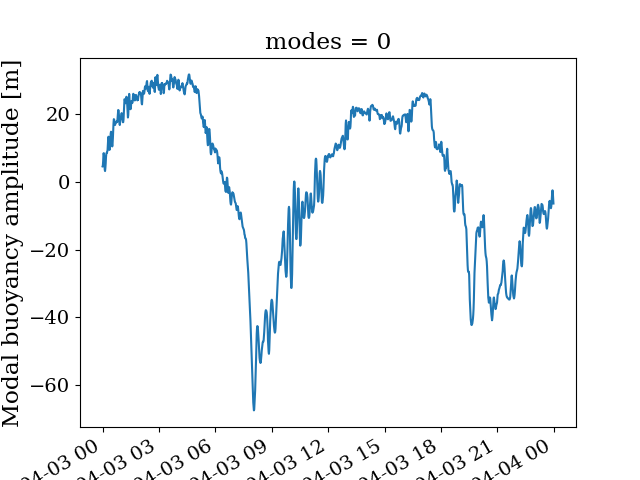

-67.60455940967898


In [107]:
Anow = A_n.sel(time='2017-04-03')
plt.figure()
Anow.plot()
print(maximum_amplitude_finder(Anow.values))


In [133]:
def fdiff(a0, A, rho, z):
    Amax = maximum_amplitude_finder(A.values)
    Aguess = runkdv(a0, rho, z)
    print(a0, Amax, Aguess )
    return (Aguess - Amax)**2.

#fdiff(30, A_n.sel(time='2017-04-01'),rhobar.sel(timeslow='2017-04-01 00:00:00').values, rhobar.z.values)

In [144]:
minimize(fdiff, [30], 
        args = (A_n.sel(time='2017-02-13'),rhobar.sel(timeslow='2017-02-14 00:00:00').values, rhobar.z.values),
        bounds=[(0,np.abs(maximum_amplitude_finder(A_n.sel(time='2017-02-13').values)) )],
        method='SLSQP', options={'eps':1e-4, 'ftol':1e-2}
        #method='CG',options={'eps':1e-4, 'gtol':1e-2}
        )

/home/suntans/code/iwaves/iwaves/kdv/solve.py:97: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  ds.merge( xray.Dataset({'B_t':Bda}), inplace=True )


[30.] -38.33124918310987 -30.049209481114485
[30.] -38.33124918310987 -30.049209481114485
[30.0001] -38.33124918310987 -30.049314410277695
[38.33124918] -38.33124918310987 -73.15153293740651
[30.83312492] -38.33124918310987 -30.92522346743914
[30.83312492] -38.33124918310987 -30.92522346743914
[30.83322492] -38.33124918310987 -30.92532892645022
[38.22774654] -38.33124918310987 -72.43582101100425
[31.57258708] -38.33124918310987 -31.752604079902195
[31.57258708] -38.33124918310987 -31.752604079902195
[31.57268708] -38.33124918310987 -31.752739068024106
[38.33124918] -38.33124918310987 -73.15153293738611
[32.24845329] -38.33124918310987 -33.502910731782315
[32.24845329] -38.33124918310987 -33.502910731782315
[32.24855329] -38.33124918310987 -33.5034015361953
[38.33124918] -38.33124918310987 -73.15153293740752
[32.85673288] -38.33124918310987 -36.631483392773234
[32.85673288] -38.33124918310987 -36.631483392773234
[32.85683288] -38.33124918310987 -36.632019620317514
[33.23684924] -38.3312

     fun: 0.00111838234653131
     jac: array([-0.3755506])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([33.16183621])

52.223896926957515